In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
cudnn.benchmark = True

In [3]:
# 1_1 1_2      2_1. 2_2.      3_1. 3_2. 3_3. 3_4.      4_1. 4_2  4_3. 4_4.      5_1. 5_2. 5_3. 5_4.  
# 64, 64, 'P', 128, 128, 'P', 256, 256, 256, 256, 'P', 512, 512, 512, 512, 'P', 512, 512, 512, 512, 'P'
channels = [64, 64, 'P', 128, 128, 'P', 256, 256, 256, 256, 'P', 512, 512, 512, 512, 'P', 512, 512, 512, 512, 'P']

In [4]:
content_layers = ['r4_2']
style_layers = ['r1_1','r2_1','r3_1','r4_1','r5_1']

In [5]:
class GramMatrix(nn.Module):
  def forward(self, x):
    B, C, H, W = x.size() # here B must be 1 
    f = x.view(C, H * W) # row -> channel, columns -> individual activation laid out horizontally
    G = torch.mm(f, f.t())
    return G.div(f.nelement())

In [21]:
class VGG19(nn.Module):
  def __init__(self):
    super(VGG19, self).__init__()
    in_channels, block_number, layer_number = 3,1,1
    self.mode = 'capture'
    self.targets, self.losses = [{l_name: torch.empty(0) for l_name in content_layers+style_layers} for i in range(2)]
  
    layers = []
    for c in channels:
      if c == 'P':
        pool = nn.AvgPool2d(kernel_size=2, stride=2)
        layers.append(pool)
        block_number+=1
        layer_number=1
      else:
        layer_name = f"r{block_number}_{layer_number}"
        conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, stride = 1, padding = 1)
        relu = nn.ReLU(inplace=True)
        if layer_name in content_layers:
          relu.register_forward_hook(self.capture_loss_hook(layer_name, True))
        elif layer_name in style_layers:
          relu.register_forward_hook(self.capture_loss_hook(layer_name, False))
        layers += [conv2d,relu]
        in_channels = c
        layer_number+=1 
    self.features = nn.Sequential(*layers, nn.AdaptiveAvgPool2d(output_size=(7,7)), nn.Flatten())
    self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 1000),
    )
    
  def capture_loss_hook(self, layer_name, is_content_loss):
       def fn(module, _ ,output):
         if self.mode == 'capture':
           self.targets[layer_name] = output
         elif self.mode == 'loss':
           if is_content_loss:
             self.losses[layer_name] = nn.MSELoss()(output, target)
           else:
             G = GramMatrix()
             target = self.targets[layer_name]
             self.losses[layer_name] = nn.MSELoss()(G(output), G(target))
       return fn

  def forward(self, x):
     out = self.features(x)
     out = self.classifier(out)
     return out
  



In [22]:
vgg = VGG19()

In [8]:
vgg19_pretrained = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [23]:
vgg.load_state_dict(vgg19_pretrained.state_dict())

<All keys matched successfully>

In [24]:
vgg.cuda()

VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPo

In [11]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [12]:
content_image = Image.open('/content/drive/My Drive/style-transfer/content_image.jpeg')

In [13]:
style_image = Image.open('/content/drive/My Drive/style-transfer/starry_night.jpeg')

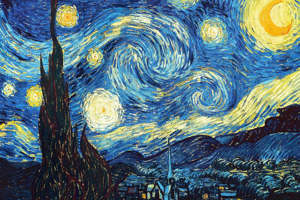

In [14]:
style_image.resize((300,200))

In [15]:
normalize_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [16]:
def preprocess_img(image, im_size):
  if type(im_size) is not tuple:
    im_size = tuple([int(im_size/max(image.size) * dim) for dim in (image.height, image.width)])
  tfms = transforms.Compose([
      transforms.Resize(im_size),
      transforms.ToTensor(),
      transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),
      transforms.Normalize(*normalize_stats),
      transforms.Lambda(lambda x: x.mul_(255))
  ])
  return tfms(image)[None,:,:,:] # same as unsqueeze(0)

In [17]:
dtype = torch.cuda.FloatTensor

In [18]:
content_tens, style_tens = preprocess_img(content_image, 512).type(dtype), preprocess_img(style_image, 512).type(dtype)

In [25]:
res = vgg(content_tens)

In [ ]:
vgg.targets